In [1]:
import tensorflow as tf
#tf.config.list_physical_devices('GPU'),tf.config.list_physical_devices('CPU')

In [2]:
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

In [3]:
import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def integral(y,x,bins):
    x_min=x
    s=0
    for i in np.where(bins>x)[0][:-1]:
#        s=s+y[i]*(bins[i+1]-bins[i])
#        print(i,s)
        s=s+y[i]*(bins[i+1]-bins[i])
    return s

class ROC:
    def __init__(self,MVA_model,X_test_scaled,y_test,MVA_model_name):
#        noise_score_1=MVA_model.predict(X_test_scaled[np.where(y_test==1)])[:,0]
#        noise_score_0=MVA_model.predict(X_test_scaled[np.where(y_test==0)])[:,0]
        signal_score_1=MVA_model.predict(X_test_scaled[np.where(y_test==1)])[:,1]
        signal_score_0=MVA_model.predict(X_test_scaled[np.where(y_test==0)])[:,1]
        
        Nbins=1000
        y_signal,bins_1,_=plt.hist(signal_score_1, bins=Nbins, alpha=0.8, label='Signal')#, density=True
        y_bkg,bins_0,_=plt.hist(signal_score_0, bins=Nbins, alpha=0.8, label='Background')#, density=True
        plt.yscale('log')
        plt.legend()
        plt.xlabel('MVA score')
        plt.savefig(MVA_model_name+'_score.pdf')
        plt.show()

        Nsignal=integral(y_signal,0,bins_1)
        Nbkg=integral(y_bkg,0,bins_0)
        signal_eff=np.array([])
        bkg_eff=np.array([])
        y_s=0
        y_n=0
        for i in range(0,Nbins+1):
            x=i/Nbins
            y_s=integral(y_signal,x,bins_1)/Nsignal
            y_n=integral(y_bkg,x,bins_0)/Nbkg
            signal_eff=np.append(y_s,signal_eff)
            bkg_eff=np.append(y_n,bkg_eff)

        #Area=round(1000*integral(signal_eff,0)/Nbins)/1000
        Area=round(1000*abs(integral(signal_eff,0,bkg_eff)))/1000
        
        lab='Area: '+str(Area)
        plt.plot(bkg_eff,signal_eff,label=lab)
        plt.plot([0,1],[0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #plt.xlim([0.001,1])
        #plt.yscale('log')
        plt.title('ROC curve')
        plt.legend()
#        plt.savefig('ROC_'+MVA_model_name+'.pdf')
        plt.show()

        WP=[0.90,0.94,0.97,0.99]
        rej=1./bkg_eff
        WP_idx=[np.where(np.abs(signal_eff-WP[i])==np.min(np.abs(signal_eff-WP[i])))[0][0] for i in range(0,len(WP))]
        #rej[WP_idx]
        WP_rej=[str(round(10*rej[WP_idx[i]])/10) for i in range(0,len(WP))]
        print(WP_rej)

        plt.plot(signal_eff,rej)
        for i in range(0,len(WP)):
            plt.axvline(x=WP[i],color='Red',linestyle='dashed',label='Bkg Rejection @ '+str(WP[i])+' WP: '+WP_rej[i])
        plt.xlabel('Signal efficiency')
        plt.ylabel('Background rejection')
        plt.xlim([0.8,1])
        plt.yscale('log')
        plt.title('ROC curve')
        plt.legend()
#        plt.savefig('rejection_ROC_'+MVA_model_name+'.pdf')
        plt.show()
        
        self.auc=Area
        self.signal_eff=signal_eff
        self.bkg_eff=bkg_eff
        self.bkg_rej=rej
        self.WP=WP
        self.WP_rej=WP_rej

In [5]:
#columns_list=np.array(['log_pt', 'eta', 'Deta', 'phi', 'Dphi', 'log_dr', 'log_ptfrac','log_p3fracJetE'])

columns_list=np.array(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac'])

In [6]:
Dir='/nfs/kloe/einstein4/martino/'
mode='VariableCone'
path=Dir+'PKL/Zprime'+mode+'/singleBJetnocut/'#'/'


In [15]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dp_f.retrieve_dataset(path)

OSError: /nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/wrongscalingJet/X_train_scaled.csv not found.

In [17]:
n_c=32
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
NN = models.Sequential()
NN.add(layers.Dense(2*n_c, activation='relu'))
#NN.add(layers.Dense(2*n_c, activation=tf.nn.sigmoid))
NN.add(layers.Dense(2*n_c, activation=tf.nn.sigmoid))
#NN.add(layers.Dense(n_c, activation='relu'))
NN.add(layers.Dense(n_c, activation=tf.nn.sigmoid))
NN.add(layers.Dense(2, activation='softmax', name='preds'))
NN.compile( optimizer=opt,
           loss='categorical_crossentropy',
#                        loss='binary_crossentropy',
                metrics = ['accuracy'])



In [19]:
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(y_train),
#                                                 y_train)

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train), 
                y_train))) 

class_weights

{0.0: 2.472824252244953, 1.0: 0.6267218809356765}

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [21]:
#NN_model_name='NN_base_rew'
#NN=tf.keras.models.load_model(path+'models/'+NN_model_name)

In [1]:
history=NN.fit(X_train_scaled, y_train_cat, batch_size=128, epochs=20, verbose=1)#validation_split=0.2,  callbacks=[callback], class_weight=class_weights,

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xscale('log')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xscale('log')

plt.tight_layout()
fig

print('accuracy:', history.history['acc'][-1], 'loss:', history.history['loss'][-1])

#print('Evaluation on training set')
#NN.evaluate(X_train_scaled, y_train_cat)
#print('Evaluation on test set')
#NN.evaluate(X_test_scaled, y_test_cat)


NameError: name 'NN' is not defined

In [28]:
print('Evaluation on test set 0')
NN.evaluate(X_test_scaled[y_test==0], y_test_cat[y_test==0])
print('Evaluation on test set 1')
NN.evaluate(X_test_scaled[y_test==1], y_test_cat[y_test==1])

Evaluation on test set 0
11085/11085 [==============================] - 1s 90us/sample - loss: 0.9037 - acc: 0.5667
Evaluation on test set 1
43853/43853 [==============================] - 4s 89us/sample - loss: 0.1531 - acc: 0.9538


[0.1531269071617779, 0.9537546]

In [29]:
model_name='NN_base'
#NN.save(path+'models/'+model_name+'/')

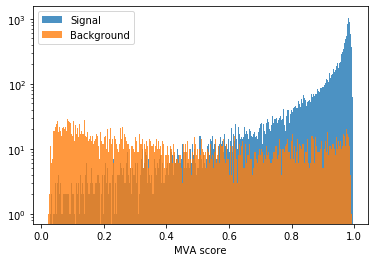

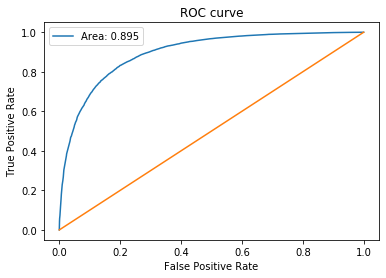

/afs/le.infn.it/user/c/centonze/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


['3.4', '2.6', '1.9', '1.4']


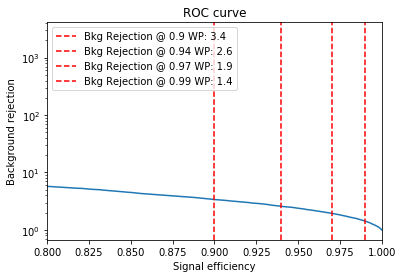

In [30]:
NN_base=ROC(NN,X_test_scaled,y_test,model_name)

REPLICATING HIGH PERFORMANCE RESULTS WITH WRONG SCALING 0

In [ ]:
Dir='/nfs/kloe/einstein4/martino/'
mode='VariableCone'
path=Dir+'PKL/Zprime'+mode+'/wrongscalingJet/'#'/singleBJetnocut/'

columns_list=np.array(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac'])

In [10]:
def retrieve_dataset(path):
    X_train_scaled=np.genfromtxt(path+"X_train.csv",delimiter=',')
    X_test_scaled=np.genfromtxt(path+"X_test.csv",delimiter=',')
    y_train=np.genfromtxt(path+"y_train.csv",delimiter=',')
    y_train_cat=np.genfromtxt(path+"y_train_cat.csv",delimiter=',')
    y_test=np.genfromtxt(path+"y_test.csv",delimiter=',')
    y_test_cat=np.genfromtxt(path+"y_test_cat.csv",delimiter=',')
    return X_train_scaled, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat

In [11]:
X_train_scaled, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=retrieve_dataset(path)

In [12]:
n_c=16

NN = models.Sequential()
NN.add(layers.Dense(2*n_c, activation='relu'))
NN.add(layers.Dense(2*n_c, activation='relu'))
NN.add(layers.Dense(2, activation='softmax', name='preds'))

In [16]:
NN.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

Train on 583608 samples
Epoch 1/100
583608/583608 [==============================] - 10s 17us/sample - loss: 0.5479 - acc: 0.7344
Epoch 2/100
583608/583608 [==============================] - 12s 21us/sample - loss: 0.5368 - acc: 0.7406
Epoch 3/100
583608/583608 [==============================] - 9s 16us/sample - loss: 0.5314 - acc: 0.7430
Epoch 4/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.5282 - acc: 0.7443
Epoch 5/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.5260 - acc: 0.7450
Epoch 6/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.5243 - acc: 0.7454
Epoch 7/100
583608/583608 [==============================] - 10s 17us/sample - loss: 0.5226 - acc: 0.7458
Epoch 8/100
583608/583608 [==============================] - 13s 23us/sample - loss: 0.5196 - acc: 0.7468
Epoch 9/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.5135 - acc: 0.7494
Epoch 10/100
583608/583608 

583608/583608 [==============================] - 13s 22us/sample - loss: 0.0563 - acc: 0.9778
Epoch 78/100
583608/583608 [==============================] - 13s 22us/sample - loss: 0.0561 - acc: 0.9779
Epoch 79/100
583608/583608 [==============================] - 14s 24us/sample - loss: 0.0559 - acc: 0.9781
Epoch 80/100
583608/583608 [==============================] - 17s 29us/sample - loss: 0.0533 - acc: 0.9790
Epoch 81/100
583608/583608 [==============================] - 9s 16us/sample - loss: 0.0536 - acc: 0.9790
Epoch 82/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.0549 - acc: 0.9783
Epoch 83/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.0529 - acc: 0.9793
Epoch 84/100
583608/583608 [==============================] - 9s 15us/sample - loss: 0.0539 - acc: 0.9788
Epoch 85/100
583608/583608 [==============================] - 10s 18us/sample - loss: 0.0520 - acc: 0.9798
Epoch 86/100
583608/583608 [==========================

KeyError: 'accuracy'

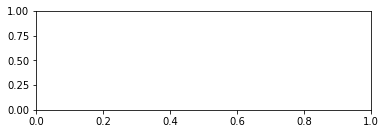

In [17]:
history=NN.fit(X_train_scaled, y_train_cat, epochs=100, batch_size=250, verbose=1)

accuracy: 0.9793834 loss: 0.05184917428322698


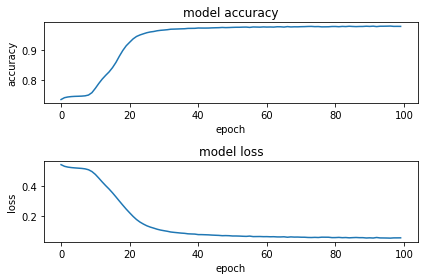

In [18]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xscale('log')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xscale('log')

plt.tight_layout()

fig
print('accuracy:', history.history['acc'][-1], 'loss:', history.history['loss'][-1])

In [19]:
print('Evaluation on test set 0')
NN.evaluate(X_test_scaled[y_test==0], y_test_cat[y_test==0])
print('Evaluation on test set 1')
NN.evaluate(X_test_scaled[y_test==1], y_test_cat[y_test==1])

Evaluation on test set 0
100189/100189 [==============================] - 7s 70us/sample - loss: 0.0372 - acc: 0.9905
Evaluation on test set 1
45713/45713 [==============================] - 3s 61us/sample - loss: 0.0610 - acc: 0.9676


[0.060954502341172986, 0.96755844]

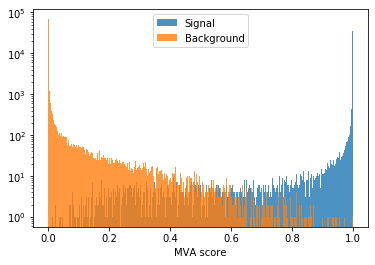

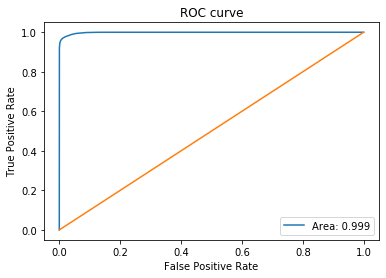

/afs/le.infn.it/user/c/centonze/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


['7156.4', '902.6', '87.8', '22.7']


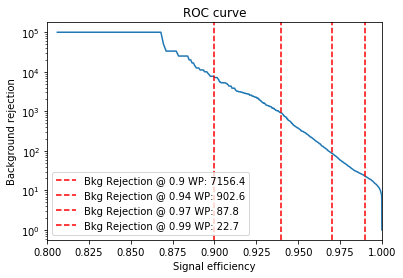

In [20]:
model_name='NN_base_wrongscaled'
#NN.save(path+'models/'+model_name+'/')
NN_base_wrongscaled=ROC(NN,X_test_scaled,y_test,model_name)